In [1]:
import codecs
from os import listdir
from os.path import join

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, TextVectorization, Embedding, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_tuner as kt

import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
def get_text(file_name): return open(file_name, 'r').read()


In [3]:
dataset_dir = "data/aclImdb"

split_names = ["train", "test"]
group_names = ["pos", "neg"]
column_names = ["text", "label"]

datasets = [{"text": [], "label": []}, {"text": [], "label": []}]


# loop over each dataset
for split in split_names:
    ds_idx = 0 if split == "train" else 1

    # loop over each group
    for group in group_names:
        label = 1 if group == "pos" else 0
        onlyfiles = [f for f in listdir(join(dataset_dir, split, group))]

        # loop over each file in the group
        for file_name in onlyfiles:
            # extract the text from the file
            text = get_text(join(dataset_dir, split, group, file_name))

            # add the text and label to the dataframe
            datasets[ds_idx]["text"].append(text)
            datasets[ds_idx]["label"].append(label)

[ds_train, ds_test] = datasets


In [4]:
x_train = ds_train["text"]
y_train = ds_train["label"]

x_test = ds_test["text"]
y_test = ds_test["label"]

In [5]:
def model_fn(hp):
    global vocab
    global embedding

    hp_maxtokens = hp.Int('max_tokens', min_value=10000,
                          max_value=80000, step=10000)
    hp_embed = hp.Int('embed', min_value=100, max_value=200, step=50)
    hp_maxlen = hp.Int('max_len', min_value=50, max_value=200, step=50)
    hp_lr = hp.Float('lr', min_value=0.00001, max_value=0.0001, step=0.00004)

    # Create the layer.
    vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=hp_maxtokens,
    output_mode='int',
    output_sequence_length=hp_maxlen)

    vectorize_layer.adapt([*x_train, *x_test])
    vocab = vectorize_layer.get_vocabulary()
    vocab_len = len(vocab)

    embedding = Embedding(vocab_len, hp_embed)

    model = Sequential()
    model.add(Input(shape=(1,), dtype=tf.string))
    model.add(vectorize_layer)
    model.add(embedding)
    model.add(Flatten())
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss='binary_crossentropy', optimizer=Adam(
        learning_rate=hp_lr), metrics=['acc'])

    return model


In [6]:
tuner = kt.Hyperband(model_fn,
                     objective='val_loss',
                     max_epochs=100,
                     factor=3,
                     directory='tuning',
                     project_name='sentimate_embedding',
                     seed=42)

2021-11-11 20:01:51.113948: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 20:01:51.120175: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 20:01:51.120709: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 20:01:51.121684: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [7]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',  mode='min', patience=3)
tuner.search(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[stop_early], shuffle=True)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.
max_tokens {best_hps.get('max_tokens')}
embed {best_hps.get('embed')}
max_len {best_hps.get('max_len')}
lr {best_hps.get('lr')}
""")


Trial 254 Complete [00h 00m 54s]
val_loss: 0.34061843156814575

Best val_loss So Far: 0.3212394416332245
Total elapsed time: 02h 25m 51s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete.
max_tokens 70000
embed 150
max_len 200
lr 9e-05



In [8]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model', monitor='val_loss',
                     mode='min', save_best_only=True, verbose=1, save_format='tf')

model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, validation_data=(
    x_test, y_test), epochs=100, verbose=0, shuffle=True, callbacks=[es, mc])



Epoch 00001: val_loss improved from inf to 0.67606, saving model to best_model


2021-11-11 22:29:58.272021: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: best_model/assets

Epoch 00002: val_loss improved from 0.67606 to 0.55224, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets

Epoch 00003: val_loss improved from 0.55224 to 0.42945, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets

Epoch 00004: val_loss improved from 0.42945 to 0.37392, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets

Epoch 00005: val_loss improved from 0.37392 to 0.34971, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets

Epoch 00006: val_loss improved from 0.34971 to 0.33269, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets

Epoch 00007: val_loss improved from 0.33269 to 0.32591, saving model to best_model
INFO:tensorflow:Assets written to: best_model/assets

Epoch 00008: val_loss did not improve from 0.32591

Epoch 00009: val_loss improved from 0.32591 to 0.32395, saving model to 

In [9]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 85.93%


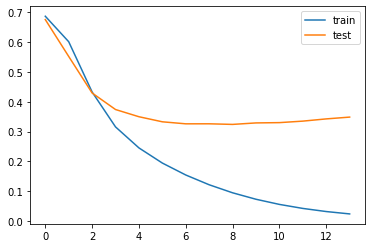

In [10]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [11]:
# listing 3.4 - Deep Learning for Natural Language Processing

def save_embedding(outputFile, weights, vocabulary):
    rev = {count: word for count, word in enumerate(vocabulary)}
    with codecs.open(outputFile, "w") as f:
        f.write(str(len(vocabulary)) + " " + str(weights.shape[1]) + "\n")
        for index in sorted(iter(rev.keys())):
            word = rev[index]
            f.write(word + " ")
            for i in list(range(len(weights[index]))):
                f.write(str(weights[index][i]) + " ")
            f.write("\n")

In [12]:
save_embedding("embedding_labeled.txt", embedding.get_weights()[0], vocab)